# Model SARIMA Implementation


In [2]:
# Basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
# Changing the path to the root of the repository

if not os.path.exists('data'):
    current_path = os.getcwd()
    root_path = os.path.abspath(os.path.join(current_path, '..'))
    os.chdir(root_path)
    print(f'Changed working directory to: {os.getcwd()}')

Changed working directory to: c:\Users\gusta\Documents\CS\energie et climat\EI\Forecast-of-Electricity-Consumption\Forecast-of-Electricity-Consumption


In [7]:
df_group_4_daily = pd.read_parquet('data/02_processed/parquet/group_4_daily.parquet')
df_group_4_daily = df_group_4_daily.groupby(['Date','Acorn'])['Conso_kWh'].sum().to_frame()


print(df_group_4_daily.head(20))

                    Conso_kWh
Date       Acorn             
2012-07-01 ACORN-C  10.305622
           ACORN-F   8.158386
           ACORN-P   5.758356
2012-07-02 ACORN-C  10.222741
           ACORN-F   7.956669
           ACORN-P   5.707083
2012-07-03 ACORN-C  10.202942
           ACORN-F   7.807432
           ACORN-P   5.703083
2012-07-04 ACORN-C   9.481093
           ACORN-F   7.810004
           ACORN-P   5.728496
2012-07-05 ACORN-C   9.526791
           ACORN-F   7.614276
           ACORN-P   5.653287
2012-07-06 ACORN-C   9.484541
           ACORN-F   7.646658
           ACORN-P   5.656040
2012-07-07 ACORN-C  10.193990
           ACORN-F   7.824191


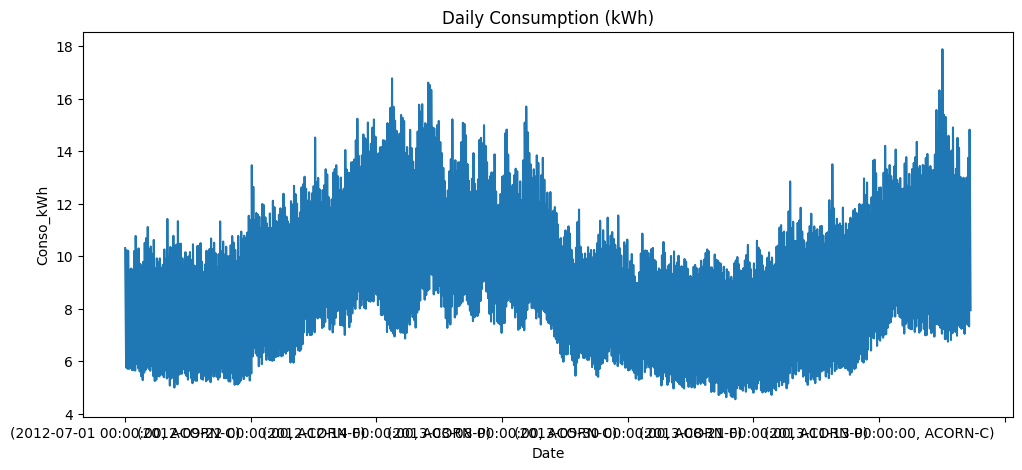

In [ ]:
df_group_4_daily['Conso_kWh'].plot(figsize=(12, 5), title='Daily Consumption (kWh)')
plt.xlabel('Date')
plt.ylabel('Conso_kWh')
plt.show()

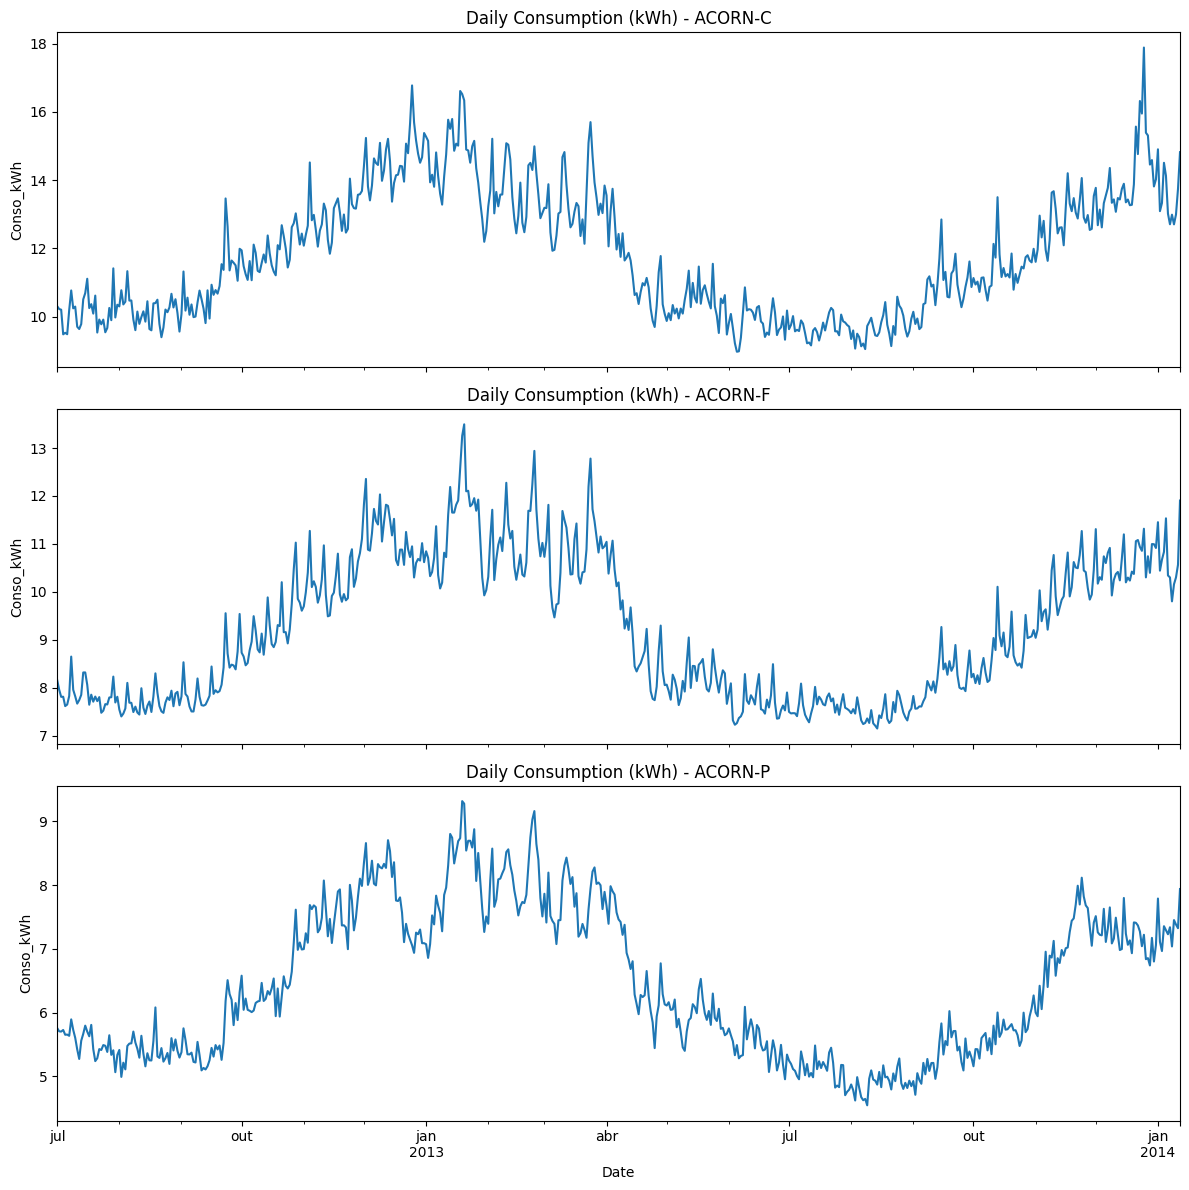

In [8]:
# Plot separate time series for each Acorn type
acorn_types = df_group_4_daily.index.get_level_values('Acorn').unique()

fig, axes = plt.subplots(len(acorn_types), 1, figsize=(12, 12), sharex=True)
for i, acorn in enumerate(acorn_types):
    df_group_4_daily.xs(acorn, level='Acorn')['Conso_kWh'].plot(ax=axes[i])
    axes[i].set_title(f'Daily Consumption (kWh) - {acorn}')
    axes[i].set_ylabel('Conso_kWh')
plt.xlabel('Date')
plt.tight_layout()
plt.show()

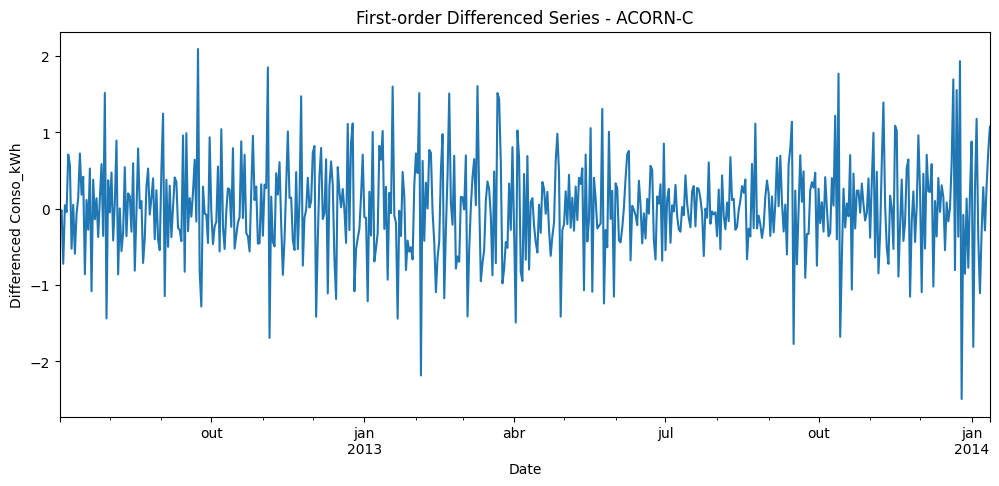

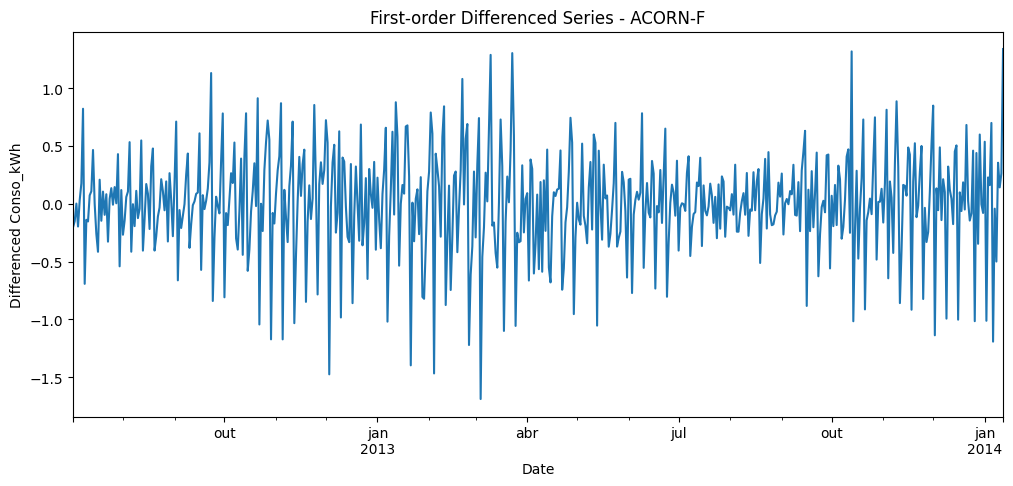

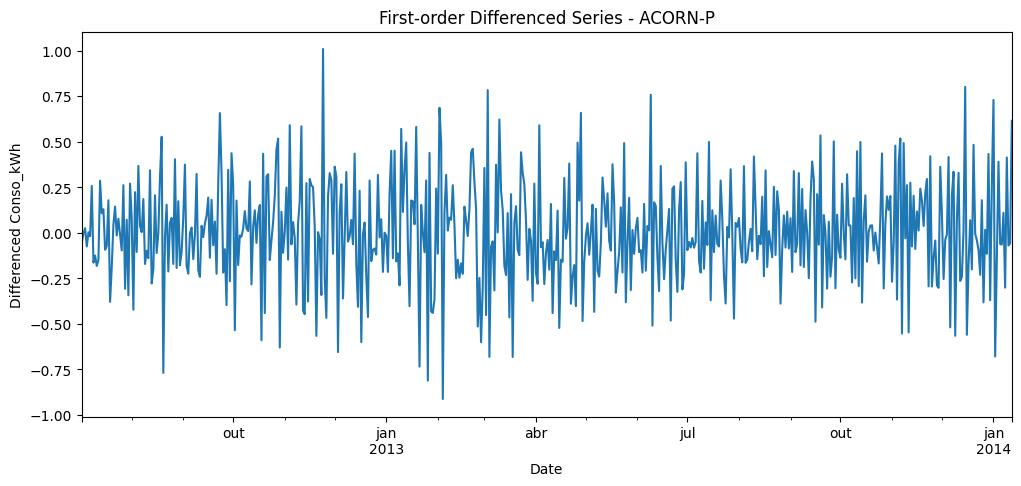

In [11]:
# Apply first-order differencing and plot for all Acorn types
for acorn in acorn_types:
    series = df_group_4_daily.xs(acorn, level='Acorn')['Conso_kWh']
    series_diff = series.diff().dropna()
    
    plt.figure(figsize=(12, 5))
    series_diff.plot(title=f'First-order Differenced Series - {acorn}')
    plt.xlabel('Date')
    plt.ylabel('Differenced Conso_kWh')
    plt.show()

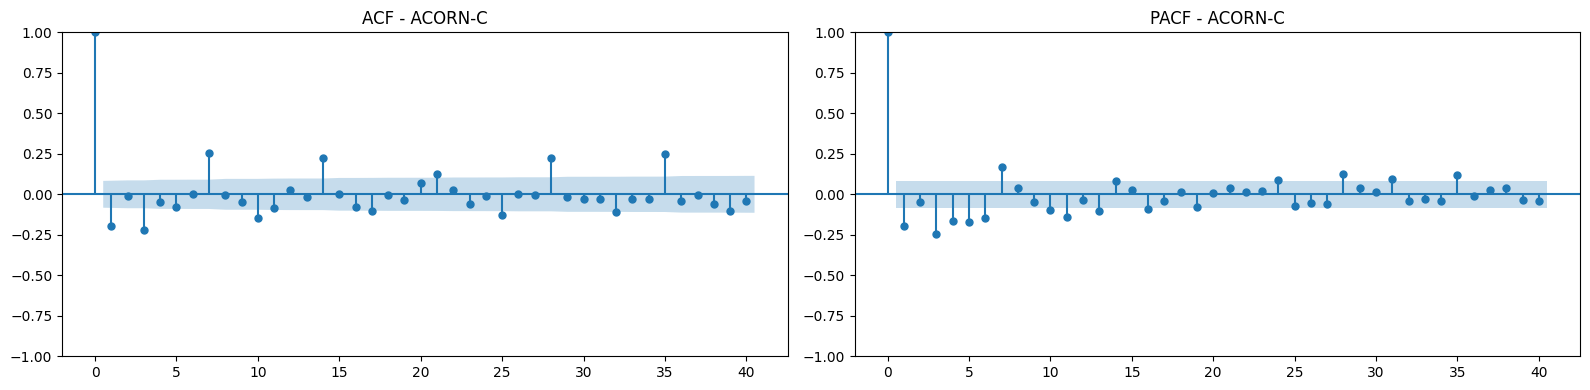

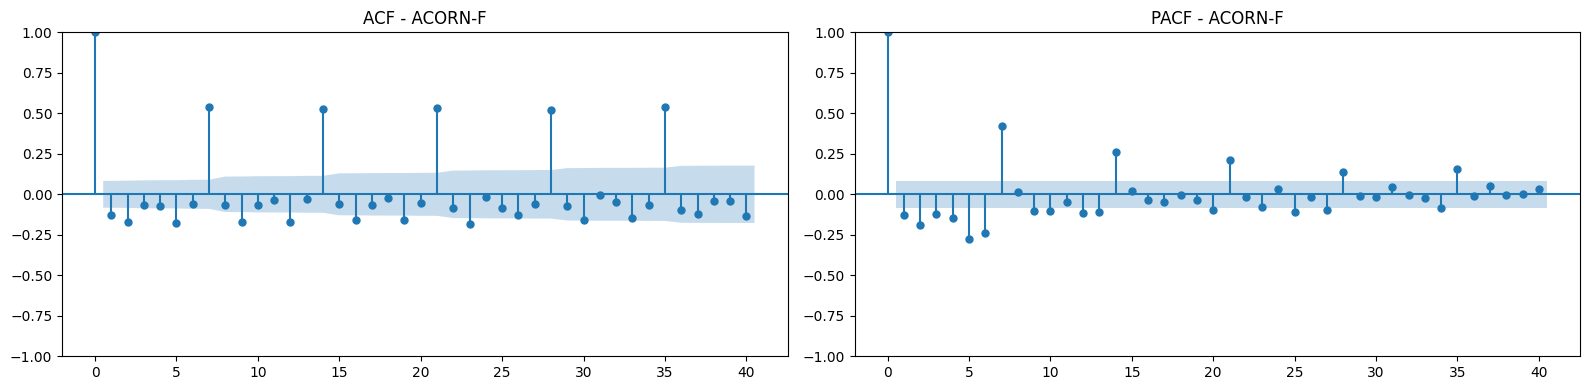

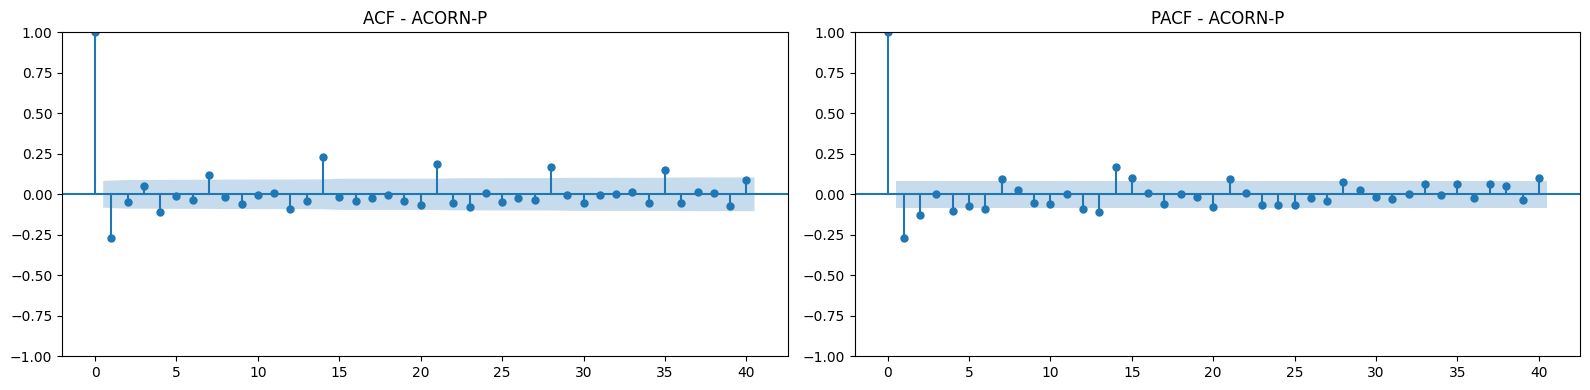

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF for each Acorn type
for acorn in acorn_types:
    series = df_group_4_daily.xs(acorn, level='Acorn')['Conso_kWh']
    series_diff = series.diff().dropna()
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))
    plot_acf(series_diff, ax=axes[0], lags=40, title=f'ACF - {acorn}')
    plot_pacf(series_diff, ax=axes[1], lags=40, title=f'PACF - {acorn}')
    plt.tight_layout()
    plt.show()

In [64]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# Apply first-order differencing to the series
def sarima_on_differenced_series(series, split_idx, acorn_label, order=(3,0,0), seasonal_order=(1,1,0,7)):
    """
    Fit SARIMA model on first-order differenced series with configurable parameters.

    Parameters:
        series (pd.Series): Original time series.
        split_idx (int): Index to split train/test.
        acorn_label (str): Label for Acorn type.
        order (tuple): SARIMA (p,d,q) order.
        seasonal_order (tuple): SARIMA seasonal (P,D,Q,s) order.

    Returns:
        model_fit_diff: Fitted SARIMAX model on differenced data.
        forecast_diff: Forecasted values on differenced scale.
        rmse: Root mean squared error on test set.
    """
    # Apply first-order differencing to the series
    series_first_diff = series.diff().dropna()

    # Split differenced series into train and test sets (aligning with original split)
    train_diff, test_diff = series_first_diff.iloc[:split_idx-1], series_first_diff.iloc[split_idx-1:]

    # Fit SARIMA model on differenced data (set d=0 since already differenced)
    model_diff = SARIMAX(train_diff, order=order, seasonal_order=seasonal_order)
    model_fit_diff = model_diff.fit(disp=False)

    # Forecast differenced values
    forecast_diff = model_fit_diff.forecast(steps=len(test_diff))

    # Print RMSE
    rmse = mean_squared_error(test_diff, forecast_diff)
    print(f'RMSE: {rmse:.3f}')
    return model_fit_diff, forecast_diff, rmse


c:\Users\gusta\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\gusta\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RMSE: 0.544


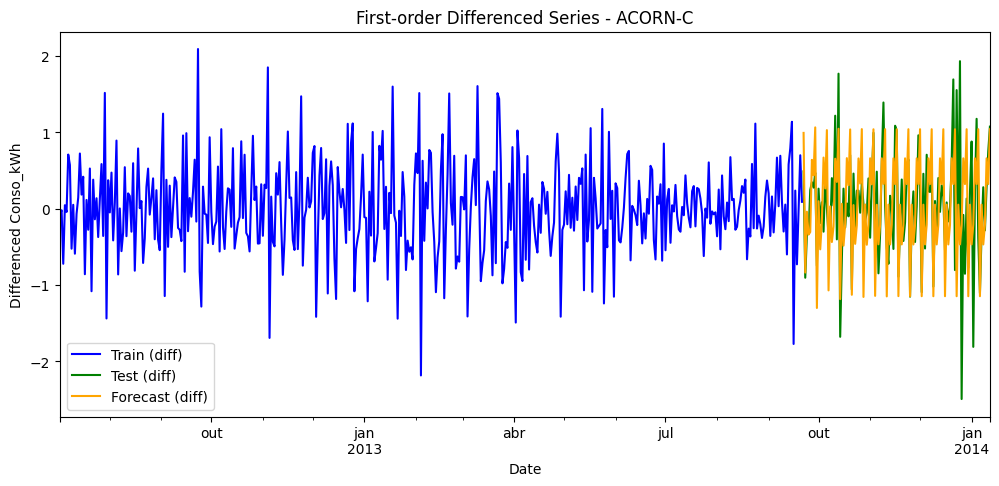

c:\Users\gusta\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\gusta\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RMSE: 0.110


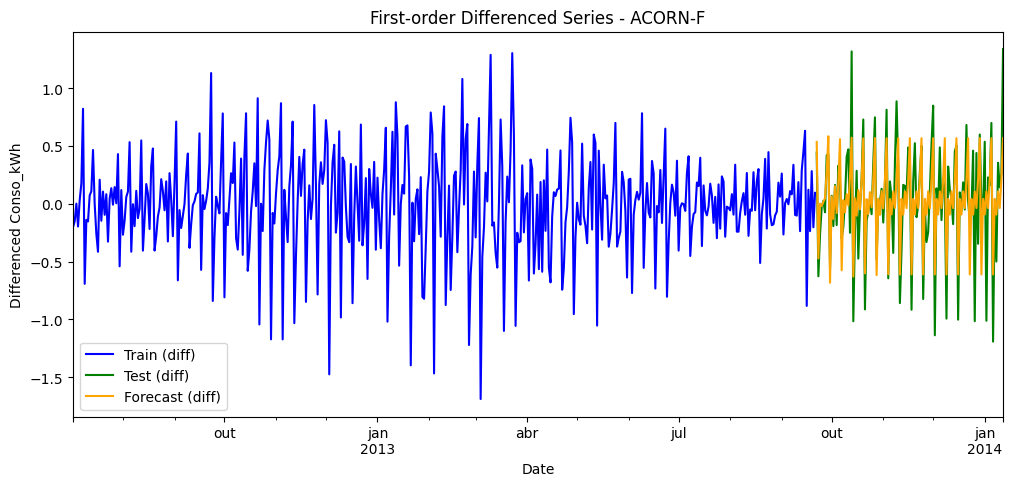

c:\Users\gusta\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\gusta\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RMSE: 0.087


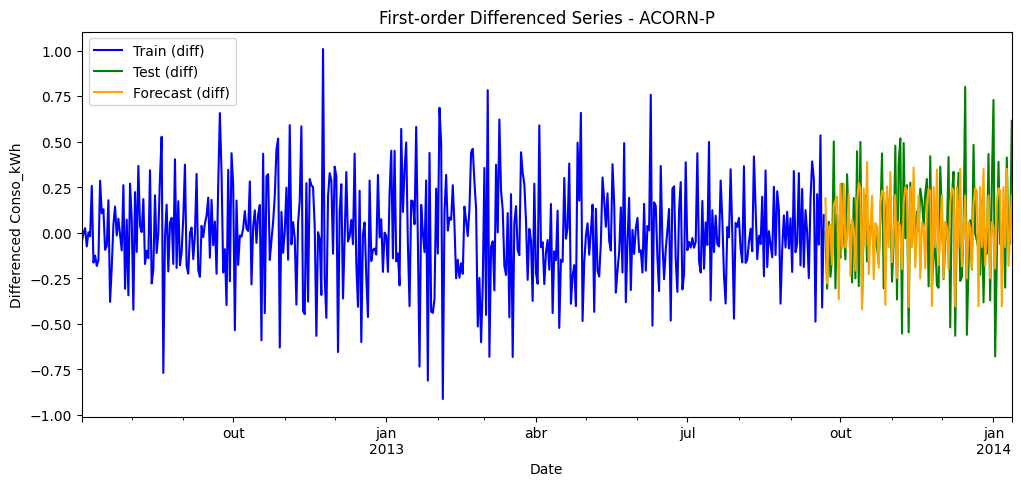

In [144]:
# Define SARIMA parameters for each Acorn type
sarima_params = {
    'ACORN-C': {'order': (2, 0, 0), 'seasonal_order': (1, 1, 0, 7)},
    'ACORN-F': {'order': (2, 0, 0), 'seasonal_order': (1, 1, 0, 7)},
    'ACORN-P': {'order': (1, 0, 1), 'seasonal_order': (1, 1, 0, 14)},
}

for acorn_label in acorn_types:
    series = df_group_4_daily.xs(acorn_label, level='Acorn')['Conso_kWh']
    series_diff = series.diff().dropna()
    train_diff = series_diff.iloc[:split_idx-1]
    test_diff = series_diff.iloc[split_idx-1:]
    params = sarima_params[acorn_label]
    _, forecast_diff, _ = sarima_on_differenced_series(
        series, split_idx, acorn_label,
        order=params['order'],
        seasonal_order=params['seasonal_order']
    )

    plt.figure(figsize=(12, 5))
    train_diff.plot(label='Train (diff)', color='blue')
    test_diff.plot(label='Test (diff)', color='green')
    forecast_diff.plot(label='Forecast (diff)', color='orange')
    plt.title(f'First-order Differenced Series - {acorn_label}')
    plt.xlabel('Date')
    plt.ylabel('Differenced Conso_kWh')
    plt.legend()
    plt.show()


c:\Users\gusta\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\gusta\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RMSE: 0.544


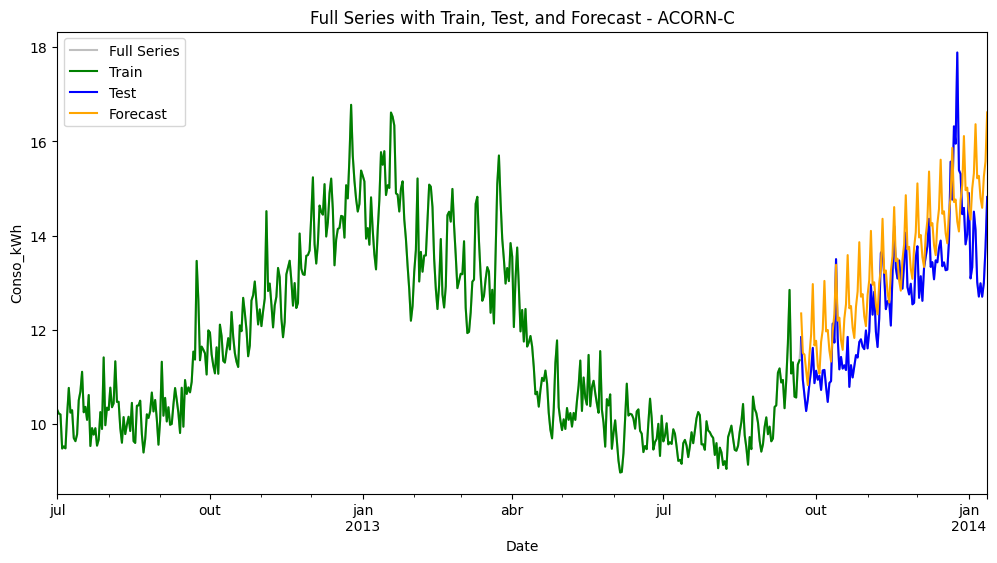

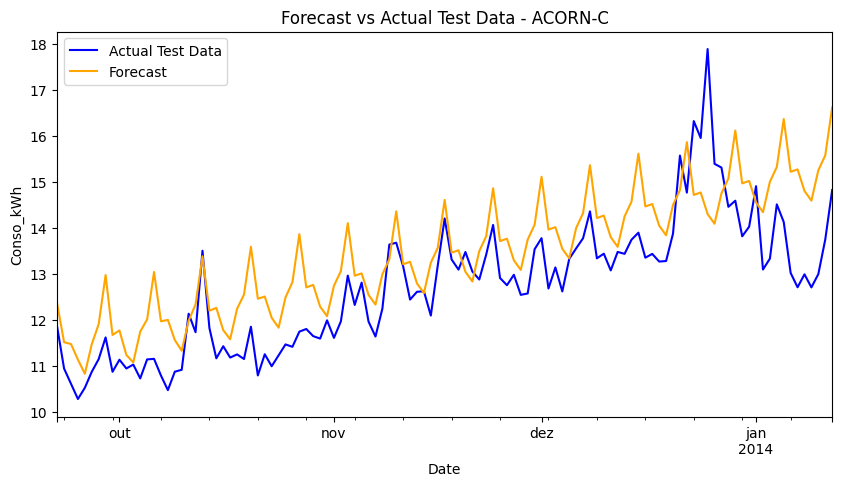

c:\Users\gusta\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\gusta\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RMSE: 0.110


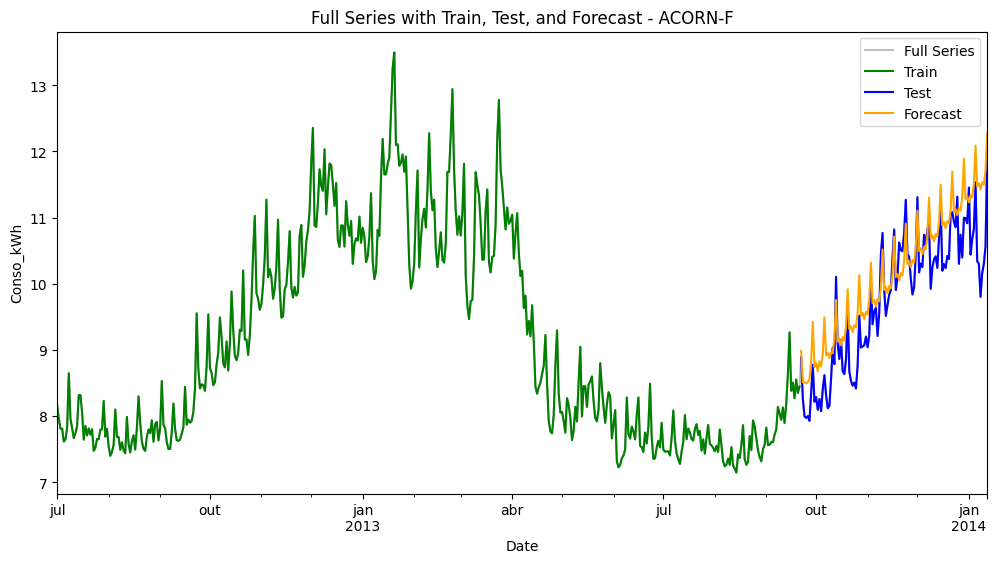

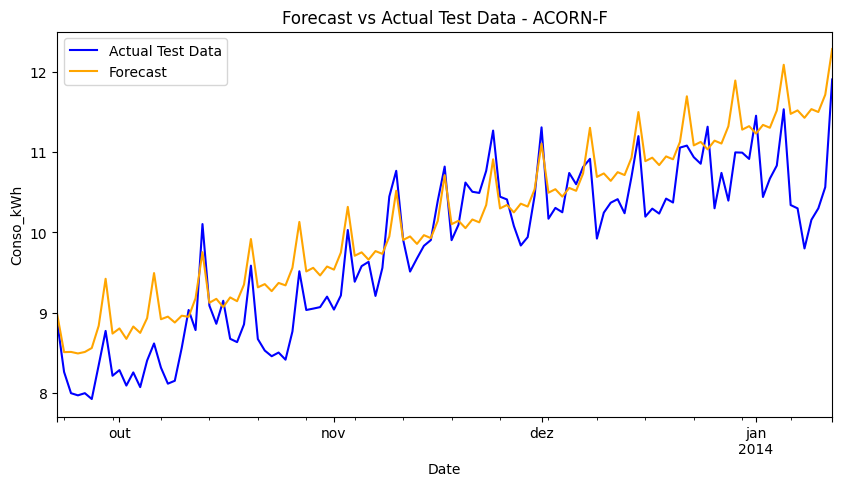

c:\Users\gusta\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\gusta\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RMSE: 0.087


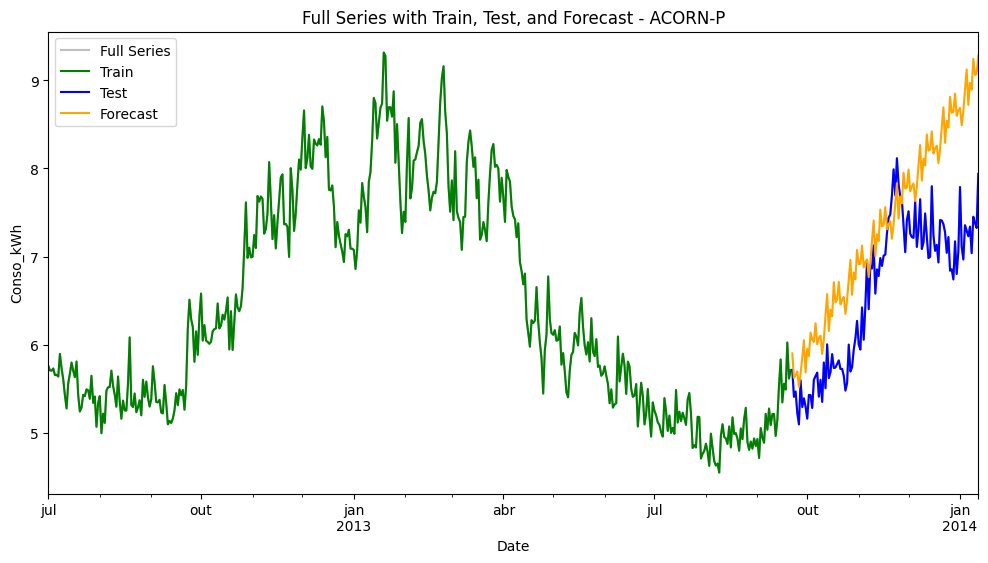

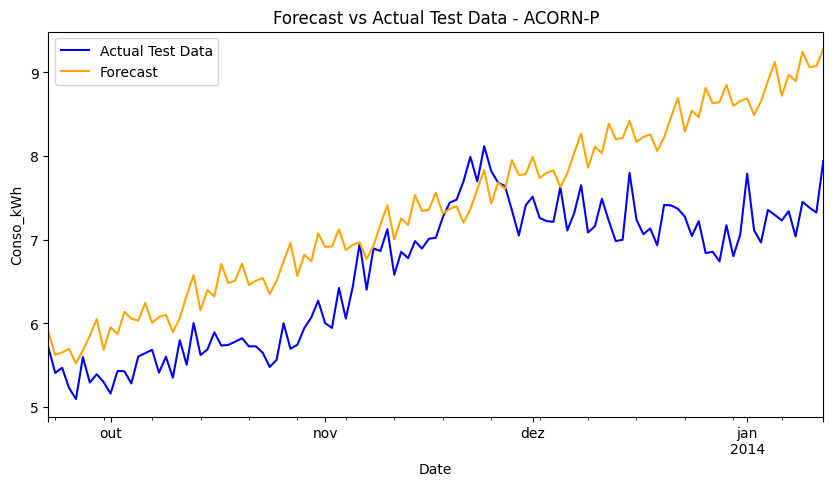

In [145]:
def invert_first_order_difference(last_train_value, forecast_diff):
    """
    Invert first-order differencing to get the original scale forecast.
    """
    forecast_inverted = forecast_diff.cumsum() + last_train_value
    forecast_inverted.index = forecast_diff.index
    return forecast_inverted

# Plot the original test data and the inverted forecast for each Acorn type using sarima_params
for acorn_label in acorn_types:
    series = df_group_4_daily.xs(acorn_label, level='Acorn')['Conso_kWh']
    last_train_value = series.iloc[split_idx - 1]
    params = sarima_params[acorn_label]
    _, forecast_diff, _ = sarima_on_differenced_series(
        series, split_idx, acorn_label,
        order=params['order'],
        seasonal_order=params['seasonal_order']
    )
    inverted_forecast = invert_first_order_difference(last_train_value, forecast_diff)
    test = series.iloc[split_idx:]
    train = series.iloc[:split_idx]

    plt.figure(figsize=(12, 6))
    series.plot(label='Full Series', color='gray', alpha=0.5)
    train.plot(label='Train', color='green')
    test.plot(label='Test', color='blue')
    inverted_forecast.plot(label='Forecast', color='orange')
    plt.title(f'Full Series with Train, Test, and Forecast - {acorn_label}')
    plt.xlabel('Date')
    plt.ylabel('Conso_kWh')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    test.plot(label='Actual Test Data', color='blue')
    inverted_forecast.plot(label='Forecast', color='orange')
    plt.title(f'Forecast vs Actual Test Data - {acorn_label}')
    plt.xlabel('Date')
    plt.ylabel('Conso_kWh')
    plt.legend()
    plt.show()

    

In [153]:
# Predict consumption from 2014-01-13 to 2014-02-13 for all 3 Acorn types using SARIMA

future_dates = pd.date_range('2014-01-13', '2014-02-13', freq='D')

future_forecasts = {}

for acorn_label in acorn_types:
    # Get the original series for this Acorn type
    series = df_group_4_daily.xs(acorn_label, level='Acorn')['Conso_kWh']
    params = sarima_params[acorn_label]
    # Fit SARIMA on the full available data (use all data up to 2014-01-12)
    model = SARIMAX(series, order=params['order'], seasonal_order=params['seasonal_order'])
    model_fit = model.fit(disp=False)
    # Forecast for the required period
    forecast = model_fit.get_forecast(steps=len(future_dates))
    forecast_series = pd.Series(forecast.predicted_mean.values, index=future_dates)
    future_forecasts[acorn_label] = forecast_series

# Display the forecasts
for acorn_label, forecast_series in future_forecasts.items():
    print(f"\nForecast for {acorn_label}:")
    print(forecast_series)

    

c:\Users\gusta\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\gusta\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\gusta\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\gusta\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\gusta\AppData\Local\Programs\Python\Python313\Lib\s


Forecast for ACORN-C:
2014-01-13    13.575016
2014-01-14    13.497332
2014-01-15    14.012077
2014-01-16    12.989782
2014-01-17    13.231781
2014-01-18    14.162709
2014-01-19    14.546298
2014-01-20    13.355492
2014-01-21    13.160595
2014-01-22    13.559939
2014-01-23    12.875401
2014-01-24    13.135264
2014-01-25    13.978934
2014-01-26    14.681659
2014-01-27    13.464831
2014-01-28    13.322842
2014-01-29    13.774595
2014-01-30    12.932075
2014-01-31    13.182874
2014-02-01    14.066513
2014-02-02    14.620416
2014-02-03    13.415320
2014-02-04    13.248450
2014-02-05    13.675616
2014-02-06    12.906362
2014-02-07    13.161237
2014-02-08    14.026188
2014-02-09    14.649190
2014-02-10    13.438574
2014-02-11    13.283219
2014-02-12    13.721774
2014-02-13    12.918430
Freq: D, dtype: float64

Forecast for ACORN-F:
2014-01-13    11.118484
2014-01-14    10.995039
2014-01-15    10.930637
2014-01-16    10.580447
2014-01-17    10.720775
2014-01-18    10.898935
2014-01-19    11.9

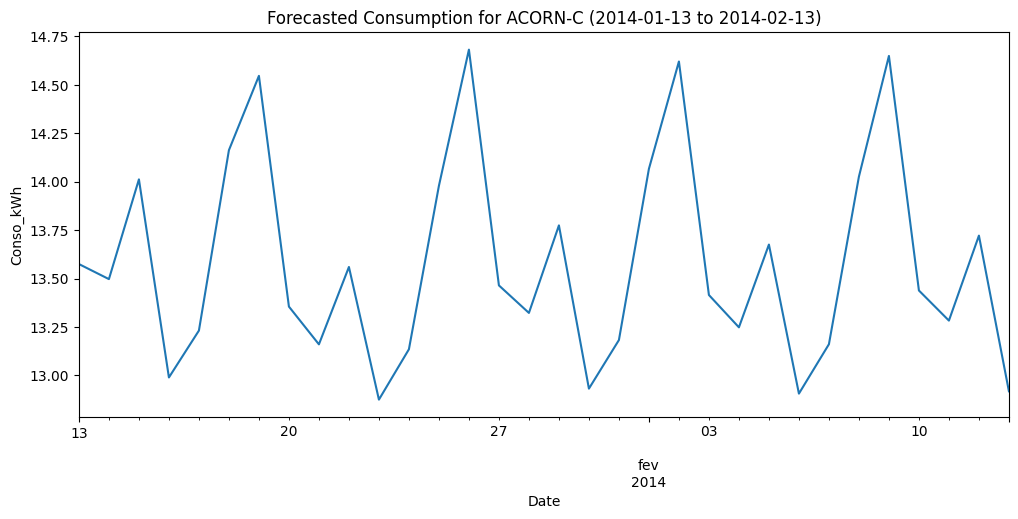

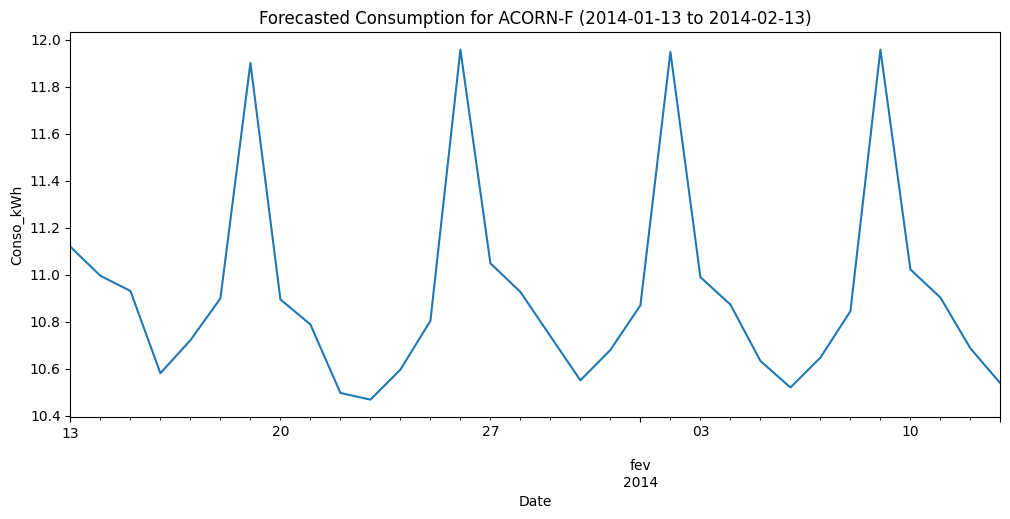

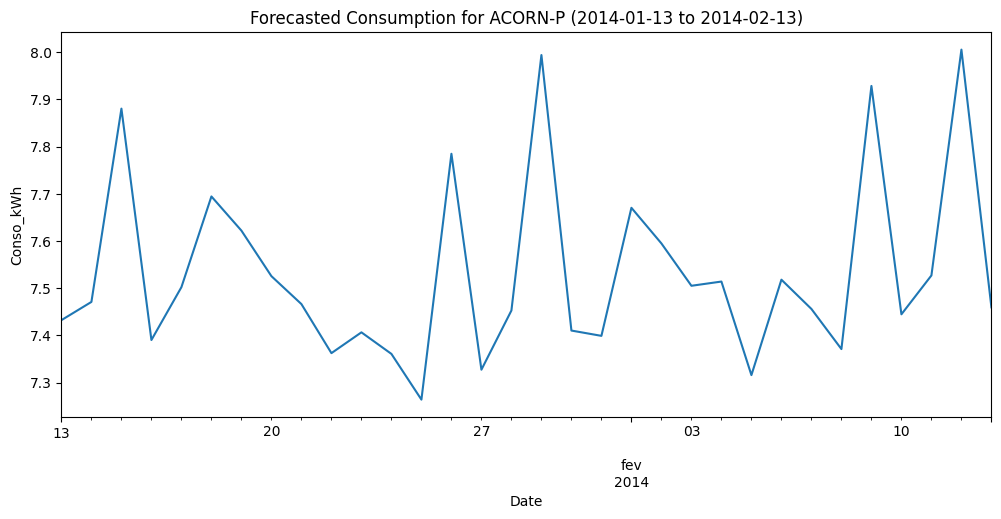

In [154]:
for acorn_label, forecast_series in future_forecasts.items():
    forecast_series.plot(figsize=(12, 5), title=f'Forecasted Consumption for {acorn_label} (2014-01-13 to 2014-02-13)')
    plt.xlabel('Date')
    plt.ylabel('Conso_kWh')
    plt.show()